# AI Model Token Cost Calculator

This notebook calculates the token counts and estimated costs for various AI models (Gemini 3.0, Claude 4.5, GPT-5 families) based on the content of `.md` and `.html` files in a specified directory.

### Models Covered:
*   **Google Gemini 3.0** (Flash, Pro)
*   **Anthropic Claude 4.5** (Haiku, Sonnet, Opus)
*   **OpenAI GPT-5** (Mini, Standard) & **o1**

> **Note:** Token counting for Gemini and Claude uses their respective API SDKs. While Gemini counting is free, valid API keys are generally required to authenticate the request. If you see "0" tokens, it is likely due to missing or invalid API keys.

In [49]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google import genai
import anthropic
import tiktoken
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set display options for Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 1. Setup Tokenizers

Initialize clients for token counting.

In [50]:
# Initialize Clients
try:
    # Try to get keys from environment loaded from .env
    # User has GEMINI_API_KEY in .env
    gemini_key = os.environ.get("GOOGLE_API_KEY") or os.environ.get("GEMINI_API_KEY")
    if not gemini_key:
         print("Warning: GEMINI_API_KEY not found in environment or .env")
    gemini_client = genai.Client(api_key=gemini_key)
except Exception as e:
    print(f"Warning initializing Gemini client: {e}")
    gemini_client = None

try:
    # Anthropic client typically looks for ANTHROPIC_API_KEY env var or explicitly passed
    # Note: Counting tokens usually requires a valid API key for the API-based method.
    claude_key = os.environ.get("ANTHROPIC_API_KEY")
    if not claude_key:
         print("Warning: ANTHROPIC_API_KEY not found in environment or .env")
    claude_client = anthropic.Anthropic(api_key=claude_key) 
except Exception as e:
    print(f"Warning initializing Anthropic client: {e}")
    claude_client = None

# OpenAI uses tiktoken which is purely local and doesn't need a client/key for counting
try:
    gpt5_encoding = tiktoken.get_encoding("o200k_base")
except Exception as e:
    print(f"Error loading tiktoken encoding: {e}")
    gpt5_encoding = None

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


## 2. Token Counting Functions

In [51]:
def count_gemini(text, model_id="gemini-3.0-flash"):
    if not gemini_client:
        return 0
    try:
        # The prompt suggests this method for counting
        # count = client.models.count_tokens(model=model_id, contents=text)
        # Note: If this actually hits an API, it might fail with a dummy key.
        count = gemini_client.models.count_tokens(model=model_id, contents=text)
        return count.total_tokens
    except Exception as e:
        # Print error once to avoid spamming
        if not hasattr(count_gemini, "_error_printed"):
            print(f"Gemini Count Error (likely needs API Key): {e}")
            count_gemini._error_printed = True
        return 0

def count_claude(text):
    if not claude_client:
        return 0
    try:
        # Claude 4.5 shared tokenizer
        # Note: 'client.messages.count_tokens' usually creates a message object logic
        # This IS an API call and requires a valid key.
        count = claude_client.messages.count_tokens(
            model="claude-4-5-sonnet-20251022", # Using user model, will fail if not real, but key is primary issue
            messages=[{"role": "user", "content": text}]
        )
        return count.input_tokens
    except Exception as e:
        if not hasattr(count_claude, "_error_printed"):
             print(f"Claude Count Error (likely needs API Key): {e}")
             count_claude._error_printed = True
        return 0

def count_openai(text):
    if not gpt5_encoding:
        return 0
    try:
        tokens = gpt5_encoding.encode(text)
        return len(tokens)
    except Exception as e:
        return 0

## 3. Pricing Configuration

Based on provided **2026 Model Output Pricing (per 1M Tokens)**.

In [52]:
PRICING_PER_1M = {
    "Gemini 3.0 Flash": 3.00,
    "Gemini 3.0 Pro": 12.00,
    "Claude 4.5 Haiku": 5.00,
    "Claude 4.5 Sonnet": 15.00,
    "Claude 4.5 Opus": 25.00,
    "GPT-OSS-120b": 0.19,
    "GPT-5-mini": 2.00,
    "GPT-5.2": 14.00,
    "OpenAI o1": 60.00
}

def calculate_cost(tokens, model_name):
    price_per_1m = PRICING_PER_1M.get(model_name, 0)
    return (tokens / 1_000_000) * price_per_1m

## 4. File Processing

In [57]:
# Configure the directory to search
TARGET_DIRECTORY = "apps/mathematics/linear_differential_equations/" # Update as needed

def get_files(directory):
    files = []
    # Updated to search for only .md and .html files
    extensions = ['*.md', '*.html']
    
    for ext in extensions:
        # Recursive search
        found = glob.glob(os.path.join(directory, '**', ext), recursive=True)
        files.extend(found)
    return files

all_files = get_files(TARGET_DIRECTORY)
if not all_files:
    # Fallback to current dir if target empty
    all_files = get_files(".")
print(f"Found {len(all_files)} files.")

Found 2 files.


## 5. Main Execution Loop

Iterate through files, count tokens for each model family, and calculate costs.

In [58]:
results = []

total_gemini_tokens = 0
total_claude_tokens = 0
total_openai_tokens = 0

print("Processing files...")
for filepath in all_files:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Count tokens
        # Gemini 3.0 family shares a tokenizer
        g_tokens = count_gemini(content, "gemini-3-flash-preview")
        # Claude 4.5 family shares a tokenizer
        c_tokens = count_claude(content)
        # GPT-5 family uses o200k_base
        o_tokens = count_openai(content)
        
        total_gemini_tokens += g_tokens
        total_claude_tokens += c_tokens
        total_openai_tokens += o_tokens
        
        results.append({
            "File": os.path.basename(filepath),
            "Path": filepath,
            "Gemini Tokens": g_tokens,
            "Claude Tokens": c_tokens,
            "OpenAI Tokens": o_tokens
        })
    except Exception as e:
        print(f"Skipping {filepath} due to error: {e}")

print(f"Finished processing. Total Files: {len(results)}")

Processing files...
Finished processing. Total Files: 2


## 6. Cost Calculation & Aggregation

In [59]:
# Aggregate totals for each specific model variant based on family token counts
model_costs = []

for model, price in PRICING_PER_1M.items():
    token_count = 0
    if "Gemini" in model:
        token_count = total_gemini_tokens
    elif "Claude" in model:
        token_count = total_claude_tokens
    elif "GPT" in model or "o1" in model:
        token_count = total_openai_tokens
        
    cost = calculate_cost(token_count, model)
    
    model_costs.append({
        "Model": model,
        "Total Tokens": token_count,
        "Total Cost ($)": cost,
        "Price per 1M": price
    })

df_costs = pd.DataFrame(model_costs).sort_values(by="Total Cost ($)", ascending=True)
print("\n--- Estimated Cost by Model ---")
display(df_costs)


--- Estimated Cost by Model ---


,Model,Total Tokens,Total Cost ($),Price per 1M
3,Claude 4.5 Sonnet,0,0.000000,15.00
2,Claude 4.5 Haiku,0,0.000000,5.00
4,Claude 4.5 Opus,0,0.000000,25.00
5,GPT-OSS-120b,6394,0.001215,0.19
6,GPT-5-mini,6394,0.012788,2.00
0,Gemini 3.0 Flash,7244,0.021732,3.00
1,Gemini 3.0 Pro,7244,0.086928,12.00
7,GPT-5.2,6394,0.089516,14.00
8,OpenAI o1,6394,0.383640,60.00


## 7. Visualization

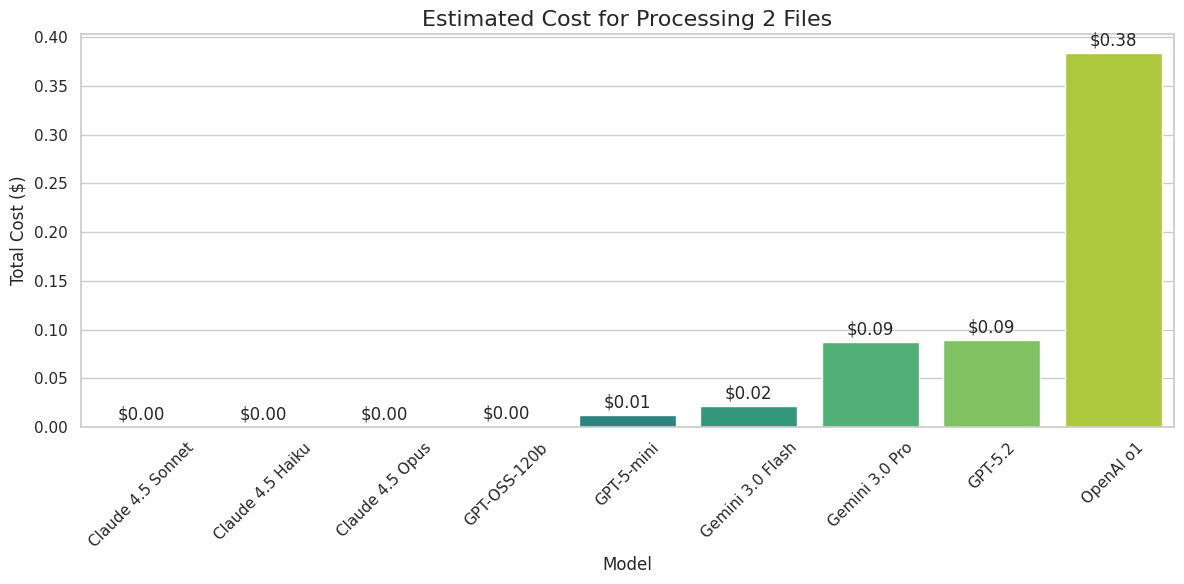

In [60]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Bar chart for Cost
chart = sns.barplot(data=df_costs, x="Model", y="Total Cost ($)", hue="Model", palette="viridis", legend=False)

plt.title(f"Estimated Cost for Processing {len(results)} Files", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Total Cost ($)", fontsize=12)
plt.xticks(rotation=45)

# Add labels on top of bars
for p in chart.patches:
    chart.annotate(f'${p.get_height():.2f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points')

plt.tight_layout()
plt.show()